(-7, 5)

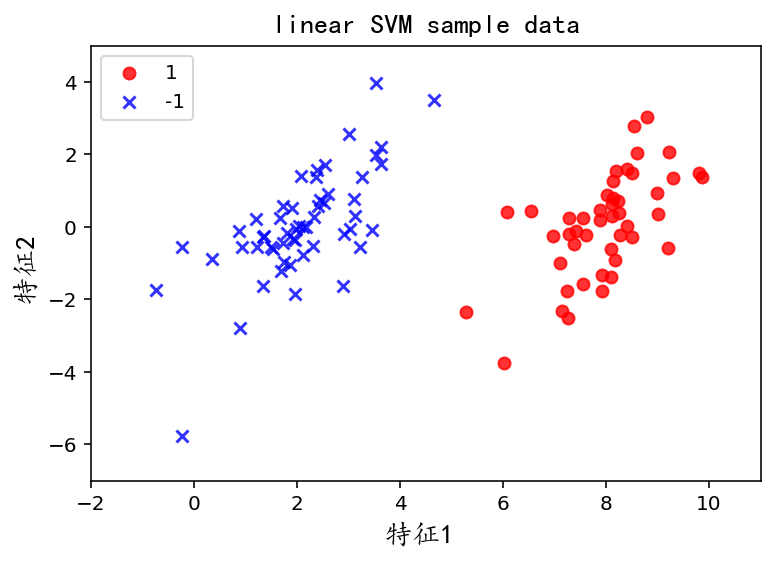

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.font_manager import FontProperties
font=FontProperties(fname=r'C:\Windows\Fonts\simkai.ttf',size=14)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


df=pd.read_table(r'E:\Repository\algorithms\SVMdata.txt',header=None)
X=df.iloc[:,[0,1]].values
y=df.iloc[:,-1].values
y.shape=(100,1)
#这一步的目的是将一维数组，转为二维数组，二维数组下就不能再y[:]这样进行索引



label=sorted(np.unique(y),reverse=True)


colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
#colors[:len(np.unique(y))]对应于不同类所要选择的颜色，二分类问题会在red,blue内进行选择
cmap = ListedColormap(colors[:len(np.unique(y))])
markers = ('o', 'x', 's', '^', 'v')
for idx,yi in enumerate(label):
        plt.scatter(x=X[y[:,0] == yi, 0], y=X[y[:,0] == yi, 1],
        alpha=0.8, c=cmap(idx),
        marker=markers[idx], label=yi)
plt.legend(loc='upper left')
plt.xlabel('特征1 ',fontproperties=font)
plt.ylabel('特征2 ',fontproperties=font)
plt.title('linear SVM sample data' ,fontproperties=font)
plt.xlim(-2,11)
plt.ylim(-7,5)
#plt.plot([0,8],[-4,4])#这样的方法可以画出直线
#y.shape



[-3.79964624] [[ 0.79935937 -0.24320356]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.11473979]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.24367698]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00393768]
 [0.35447909]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  

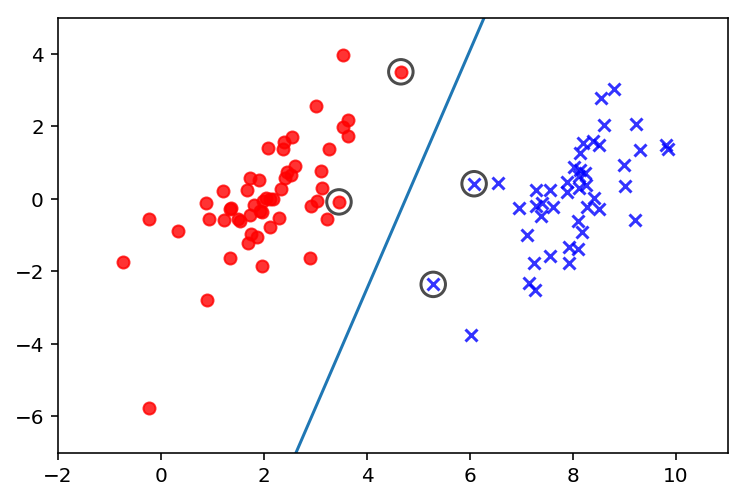

In [4]:
#用简化版SMO算法进行求解最大间隔超平面
import random

#检查每一个训练样本是否满足KKT条件，不满足则其对应的alpha作为第一个优化的alpha1
#然后随机选取另外一个alpha作为alpha2进行优化

def select_alpha2(i,m):
    #i为alpha1对应的样本
    #m为总样本数，选出与样本i不同的样本
    j=i
    while(j==i):
        j=random.randint(0,m-1)
    return j

def clip_alpha(alpha,H,L):
    if alpha>H:
        alpha=H
    elif alpha<L:
        alpha=L
    return alpha

#计算样本i对应的预测值yulabel之间的误差
def error(X,y,alpha,b,i):
    alpha_y=(np.multiply(alpha,y)).T
    kernel=np.dot(X,X[i,:])
    predicty=alpha_y.dot(kernel)+b
    error=predicty-y[i]
    return error
    
    
def simplify_smo(X,y,C,tolerate,maxiter):
    #找出数据维度
    m,n=X.shape
    #初始化alpha
    alpha=np.zeros((m,1))
    #注意，创建多维数组是要用元祖形式创建
    #初始迭代次数
    iterbegin=0
    b=0
    while iterbegin<=maxiter:
        alphaPairsChanged = 0
        #开始找第一个aplha
        for i in range(m):
            #步骤一：开始找一对儿aplha
            Ei=error(X,y,alpha,b,i)
            if ((Ei*y[i]<-tolerate) and alpha[i]<C) or ((Ei*y[i]>tolerate) and alpha[i]>0):
            #if 0<=alpha[i]<C and ((Ei*y[i]>tolerate) or(Ei*y[i]<-tolerate)):
                #此Ei对应样本违反KKT条件较多，选取它为第一个alpha1
                #随机选取第二个alpha
                j=select_alpha2(i,m)
                Ej=error(X,y,alpha,b,j)
                #对这两个alpha进行深度拷贝，便于后面修改
                alphaI_old=alpha[i].copy()
                alphaJ_old=alpha[j].copy()
            # 步骤二：计算上界和下界
                if y[i]==y[j]:
                    H=min(C,alphaI_old+alphaJ_old)
                    L=max(0,alphaI_old+alphaJ_old-C)
                else:
                    H=min(C,C+alphaJ_old-alphaI_old)
                    L=max(0,alphaJ_old-alphaI_old)
                if H==L:
                    #print('H==L')
                    continue

            #步骤三：计算eta
                eta=np.dot((X[i]-X[j]),(X[i]-X[j]))
                if eta<=0:
                    #print('eta<=0')
                    continue
            #步骤四：不考虑约束下修正alphaJ即alpha2
                alpha[j]=alpha[j]+(y[j]*(Ei-Ej))/eta
            #步骤五：修剪alphaJ
                alpha[j]=clip_alpha(alpha[j],H,L)
                if (abs(alpha[j]-alphaJ_old))<0.00001:
                    #print('alphaJ变化太小')
                    continue
            #步骤六：修正alpha[i]
                alpha[i]=alpha[i]+y[i]*y[j]*(alphaJ_old-alpha[j])
                
            #步骤七：修正阈值b
                b1=-Ei-y[i]*np.dot(X[i],X[i])*(alpha[i]-alphaI_old)-y[j]*np.dot(X[i],X[j])*(alpha[j]-alphaJ_old)+b
                b2=-Ej-y[i]*np.dot(X[i],X[j])*(alpha[i]-alphaI_old)-y[j]*np.dot(X[j],X[j])*(alpha[j]-alphaJ_old)+b

                if 0<alpha[i]<C:
                    b=b1
                elif 0<alpha[j]<C:
                    b=b2
                else:
                    b=(b1+b2)/2
                alphaPairsChanged += 1
                #打印统计信息
                #print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iterbegin,i,alphaPairsChanged))
        if (alphaPairsChanged == 0):
            
            iterbegin += 1
        else: 
            iterbegin = 0
        #print("迭代次数: %d" % iterbegin)        

    return b,alpha

def get_w(X,y,alpha):
    alpha_y=(np.multiply(alpha,y)).T
    w=np.dot(alpha_y,X)
    return w

def showclassifier(X,y,w,b,alpha):
    for idx,yi in enumerate(sorted(np.unique(y))):
        plt.scatter(x=X[y[:,0] == yi, 0], y=X[y[:,0] == yi, 1],
        alpha=0.8, c=cmap(idx),
        marker=markers[idx], label=yi)
    w1=w[0,0]
    w2=w[0,1]
    xmin=X.min(axis=0)[0]
    xmax=X.max(axis=0)[0]
    y1=(-b-w1*xmin)/w2
    y2=(-b-w1*xmax)/w2
    plt.plot([xmin,xmax],[y1,y2])
    plt.xlim(-2,11)
    plt.ylim(-7,5)
    for i, alpha in enumerate(alpha):
        if 0<abs(alpha)<0.6:
            x, y = X[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='black')
    
if __name__=='__main__':
    b,alpha=simplify_smo(X,y,0.6,0.001,40)
    w=get_w(X,y,alpha)
    showclassifier(X,y,w,b,alpha)
    print(b,w)
    #spend_time=time.clock()-start
    print(alpha)
    
    
    
    
    
                
                
                
                
            
        
    

    


